### Пояснения к заданиям

Все задания необходимо решать аналитически. Если полученный дифур получается нерешаемым, разложить в нужной окрестности по Тейлору и оставить необходимое количество членов для того чтобы симуляция все еще отражало суть задачи, но дифур решался аналитически. В задачах эффекты, которые можно наблюдать нелинейные и при линеаризации не получается их показать. В таком случае нужно показать, что эти эффекты нелинейны, получить решаемый дифур и просимулировать то что получилось, подставив адекватные значения.

Считать угол постоянным, остальное переменным.
Использовать sympy  или похожие системы. Не нужно делать это вручную

## Preprocessing

In [3]:
# !pip install matplotlib
# !pip install sympy
# !pip install numpy

In [ ]:
import matplotlib
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from matplotlib import animation
import math

sp.init_printing(use_unicode=True)
matplotlib.rcParams['animation.embed_limit'] = 50

# CONSTEXPR
T = 14 # time
FPS = 30
TOTAL_FRAMES = T * FPS
DT = 1.0 / FPS
SEPARATOR = '_' * 48

In [ ]:
def get_spring_color(current_length, natural_length, k_val):
    tension = k_val * abs(current_length - natural_length)
    max_tension = 1.0
    normalized_tension = min(tension / max_tension, 1.0)
    red = normalized_tension
    blue = 1.0 - normalized_tension
    green = 0.0
    return (red, green, blue)

def semi_implicit_euler_full(force_function_x, force_function_y, mass, x0, y0, vx0, vy0, dt=DT, t_end=T):
    t_array = np.arange(0, t_end, dt)
    n_steps = len(t_array)
    
    x_arr = np.zeros(n_steps)
    y_arr = np.zeros(n_steps)
    vx_arr = np.zeros(n_steps)
    vy_arr = np.zeros(n_steps)
    
    x_arr[0] = x0
    y_arr[0] = y0
    vx_arr[0] = vx0
    vy_arr[0] = vy0
    
    for i in range(1, n_steps):
        x_curr = x_arr[i-1]
        y_curr = y_arr[i-1]
        vx_curr = vx_arr[i-1]
        vy_curr = vy_arr[i-1]
        
        Fx = force_function_x(x_curr, y_curr)
        Fy = force_function_y(x_curr, y_curr)
        
        ax = Fx / mass
        ay = Fy / mass
        
        vx_new = vx_curr + dt * ax
        vy_new = vy_curr + dt * ay
        
        x_new = x_curr + dt * vx_new
        y_new = y_curr + dt * vy_new
        
        x_arr[i] = x_new
        y_arr[i] = y_new
        vx_arr[i] = vx_new
        vy_arr[i] = vy_new
    
    return t_array, x_arr, y_arr, vx_arr, vy_arr

def semi_implicit_euler_linear(C_xx_num, C_xy_num, C_yx_num, C_yy_num, mass, x0, y0, vx0, vy0, dt=DT, t_end=T):
    t_array = np.arange(0, t_end, dt)
    n_steps = len(t_array)
    
    x_arr = np.zeros(n_steps)
    y_arr = np.zeros(n_steps)
    vx_arr = np.zeros(n_steps)
    vy_arr = np.zeros(n_steps)
    
    x_arr[0] = x0
    y_arr[0] = y0
    vx_arr[0] = vx0
    vy_arr[0] = vy0
    
    for i in range(1, n_steps):
        x_curr = x_arr[i-1]
        y_curr = y_arr[i-1]
        vx_curr = vx_arr[i-1]
        vy_curr = vy_arr[i-1]
        
        Fx = C_xx_num * x_curr + C_xy_num * y_curr
        Fy = C_yx_num * x_curr + C_yy_num * y_curr
        
        ax = Fx / mass
        ay = Fy / mass
        
        vx_new = vx_curr + dt * ax
        vy_new = vy_curr + dt * ay
        
        x_new = x_curr + dt * vx_new
        y_new = y_curr + dt * vy_new
        
        x_arr[i] = x_new
        y_arr[i] = y_new
        vx_arr[i] = vx_new
        vy_arr[i] = vy_new
    
    return t_array, x_arr, y_arr, vx_arr, vy_arr

def setup_animation_plots(fig, title, anchor_points, margin=1.0):
    (ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)
    
    # Главный график с системой
    all_x = [point[0] for point in anchor_points]
    all_y = [point[1] for point in anchor_points]
    ax1.set_xlim(min(all_x) - margin, max(all_x) + margin)
    ax1.set_ylim(min(all_y) - margin, max(all_y) + margin)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_title(title)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    # Сравнение траекторий
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Сравнение траекторий')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    # График x(t)
    ax3.set_xlabel('t, с')
    ax3.set_ylabel('x(t)')
    ax3.set_title('Координата x(t)')
    ax3.grid(True, alpha=0.3)
    
    # График y(t)
    ax4.set_xlabel('t, с')
    ax4.set_ylabel('y(t)')
    ax4.set_title('Координата y(t)')
    ax4.grid(True, alpha=0.3)
    
    return ax1, ax2, ax3, ax4

def create_spring_animation(task_name, anchor_points, spring_lengths, spring_constants, 
                          force_function_x, force_function_y, spring_length_functions,
                          C_coefficients, num_prms, x0, y0, vx0=0.0, vy0=0.0):
    
    C_xx_num, C_xy_num, C_yx_num, C_yy_num = C_coefficients
    mass = num_prms[m]
    
    t_full, x_full, y_full, vx_full, vy_full = semi_implicit_euler_full(
        force_function_x, force_function_y, mass, x0, y0, vx0, vy0
    )
    t_linear, x_linear, y_linear, vx_linear, vy_linear = semi_implicit_euler_linear(
        C_xx_num, C_xy_num, C_yx_num, C_yy_num, mass, x0, y0, vx0, vy0
    )
    
    print(f"{task_name}:")
    
    fig = plt.figure(figsize=(16, 12))
    ax1, ax2, ax3, ax4 = setup_animation_plots(fig, task_name, anchor_points)
    
    mass_point, = ax1.plot([], [], 'ko', markersize=12, label='Объект')
    spring_lines = []
    for i in range(len(anchor_points)):
        line, = ax1.plot([], [], linewidth=5)
        spring_lines.append(line)
    
    trajectory_full, = ax1.plot([], [], 'r--', alpha=0.7, label='Нелинейная траектория')
    trajectory_linear, = ax1.plot([], [], 'orange', linestyle=':', alpha=0.8, label='Линейная траектория')
    
    for i, point in enumerate(anchor_points):
        ax1.plot(point[0], point[1], 'ks', markersize=10)
    ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    ax2.plot(x_full, y_full, 'r-', label='Нелинейная', linewidth=2)
    ax2.plot(x_linear, y_linear, 'orange', linestyle='--', label='Линеаризованная', linewidth=2)
    current_point_full, = ax2.plot([], [], 'ro', color='black', markersize=8)
    current_point_linear, = ax2.plot([], [], 'o', color='grey', markersize=8)
    ax2.legend(loc='upper right')
    
    ax3.plot(t_full, x_full, 'r-', label='x нелинейная', linewidth=2)
    ax3.plot(t_linear, x_linear, 'orange', linestyle='--', label='x линейная', linewidth=2)
    ax3.legend(loc='upper right')
    x_time_line = ax3.axvline(x=0, color='k', linestyle=':', alpha=0.7)
    
    ax4.plot(t_full, y_full, 'r-', label='y нелинейная', linewidth=2)
    ax4.plot(t_linear, y_linear, 'orange', linestyle='--', label='y линейная', linewidth=2)
    ax4.legend(loc='upper right')
    y_time_line = ax4.axvline(x=0, color='k', linestyle=':', alpha=0.7)
    
    def animate(frame):
        if frame < len(t_full):
            current_time = t_full[frame]
            x_curr, y_curr = x_full[frame], y_full[frame]
            x_curr_linear, y_curr_linear = x_linear[frame], y_linear[frame]
            
            mass_point.set_data([x_curr], [y_curr])
            
            tension_info = []
            for i, (anchor, spring_func, k_val, natural_length) in enumerate(
                zip(anchor_points, spring_length_functions, spring_constants, spring_lengths)
            ):
                current_length = spring_func(x_curr, y_curr)
                color = get_spring_color(current_length, natural_length, k_val)
                spring_lines[i].set_data([anchor[0], x_curr], [anchor[1], y_curr])
                spring_lines[i].set_color(color)
                
                tension = k_val * abs(current_length - natural_length)
                tension_info.append(f'L{i+1}={current_length:.2f}(T={tension:.2f})')
            
            trajectory_full.set_data(x_full[:frame+1], y_full[:frame+1])
            trajectory_linear.set_data(x_linear[:frame+1], y_linear[:frame+1])
            
            current_point_full.set_data([x_curr], [y_curr])
            current_point_linear.set_data([x_curr_linear], [y_curr_linear])
            
            x_time_line.set_xdata([current_time])
            y_time_line.set_xdata([current_time])
            
            ax1.set_title(''.join(tension_info))
        
        return [mass_point] + spring_lines + [trajectory_full, trajectory_linear, 
                current_point_full, current_point_linear]
    
    anim = animation.FuncAnimation(
        fig, animate, frames=TOTAL_FRAMES, 
        interval=1000//FPS, blit=False, repeat=True
    )
    
    plt.tight_layout()
    
    name = f'{task_name.lower().replace(" ", "_").replace("-", "_")}.gif'
    anim.save(name, writer='pillow', fps=FPS)
    print(f"Анимация сохранена: {name}")
    
    plt.show()
    return anim

## Task 0

![Дополненный рисунок к 0 task](./images/pict_0.png)

### T0: Аналитическое решение 


Система уравнений:


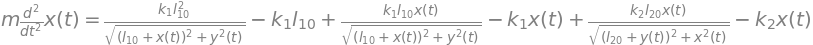

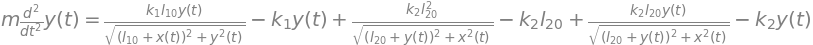

________________________________________________

Линеаризованная система уравнений:


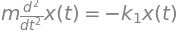

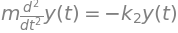

________________________________________________


In [6]:
t = sp.symbols('t')
m, k1, k2 = sp.symbols('m k1 k2', positive=True)
l1_0, l2_0 = sp.symbols('l10 l20', positive=True)

x_func = sp.Function('x')(t)
y_func = sp.Function('y')(t)

x_s, y_s = sp.symbols('x y')

vec_PA_x_s = x_s - (-l1_0) 
vec_PA_y_s = y_s - 0       
vec_PB_x_s = x_s - 0      
vec_PB_y_s = y_s - (-l2_0)  

L1_expr_s = sp.sqrt(vec_PA_x_s**2 + vec_PA_y_s**2)
L2_expr_s = sp.sqrt(vec_PB_x_s**2 + vec_PB_y_s**2)

F1_full_s = k1 * (L1_expr_s - l1_0)
F2_full_s = k2 * (L2_expr_s - l2_0)

F1x_s = -F1_full_s * (vec_PA_x_s / L1_expr_s)
F1y_s = -F1_full_s * (vec_PA_y_s / L1_expr_s)
F2x_s = -F2_full_s * (vec_PB_x_s / L2_expr_s)
F2y_s = -F2_full_s * (vec_PB_y_s / L2_expr_s)

Fx_total_sym = sp.simplify(F1x_s + F2x_s)
Fy_total_sym = sp.simplify(F1y_s + F2y_s)

eq_x_full = sp.Eq(m * x_func.diff(t, 2), Fx_total_sym.subs({x_s: x_func, y_s: y_func}))
eq_y_full = sp.Eq(m * y_func.diff(t, 2), Fy_total_sym.subs({x_s: x_func, y_s: y_func}))

print("\nСистема уравнений:")
display(eq_x_full, eq_y_full)

print(SEPARATOR)

dFx_dx = sp.diff(Fx_total_sym, x_s)
dFx_dy = sp.diff(Fx_total_sym, y_s)
dFy_dx = sp.diff(Fy_total_sym, x_s)
dFy_dy = sp.diff(Fy_total_sym, y_s)

equilibrium_point = {x_s: 0, y_s: 0}

C_xx = sp.simplify(dFx_dx.subs(equilibrium_point))
C_xy = sp.simplify(dFx_dy.subs(equilibrium_point))
C_yx = sp.simplify(dFy_dx.subs(equilibrium_point))
C_yy = sp.simplify(dFy_dy.subs(equilibrium_point))

Fx_linear = C_xx * x_func + C_xy * y_func
Fy_linear = C_yx * x_func + C_yy * y_func

eq_x_linear = sp.Eq(m * x_func.diff(t, 2), Fx_linear)
eq_y_linear = sp.Eq(m * y_func.diff(t, 2), Fy_linear)

print("\nЛинеаризованная система уравнений:")
display(eq_x_linear)
display(eq_y_linear)

print(SEPARATOR)

### T0: Визуализация

Task_0_90_degree:


C:\Users\evoni\AppData\Local\Temp\ipykernel_51844\1194476643.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_point_full, = ax2.plot([], [], 'ro', color='black', markersize=8)


Анимация сохранена: task_0_90_degree.gif


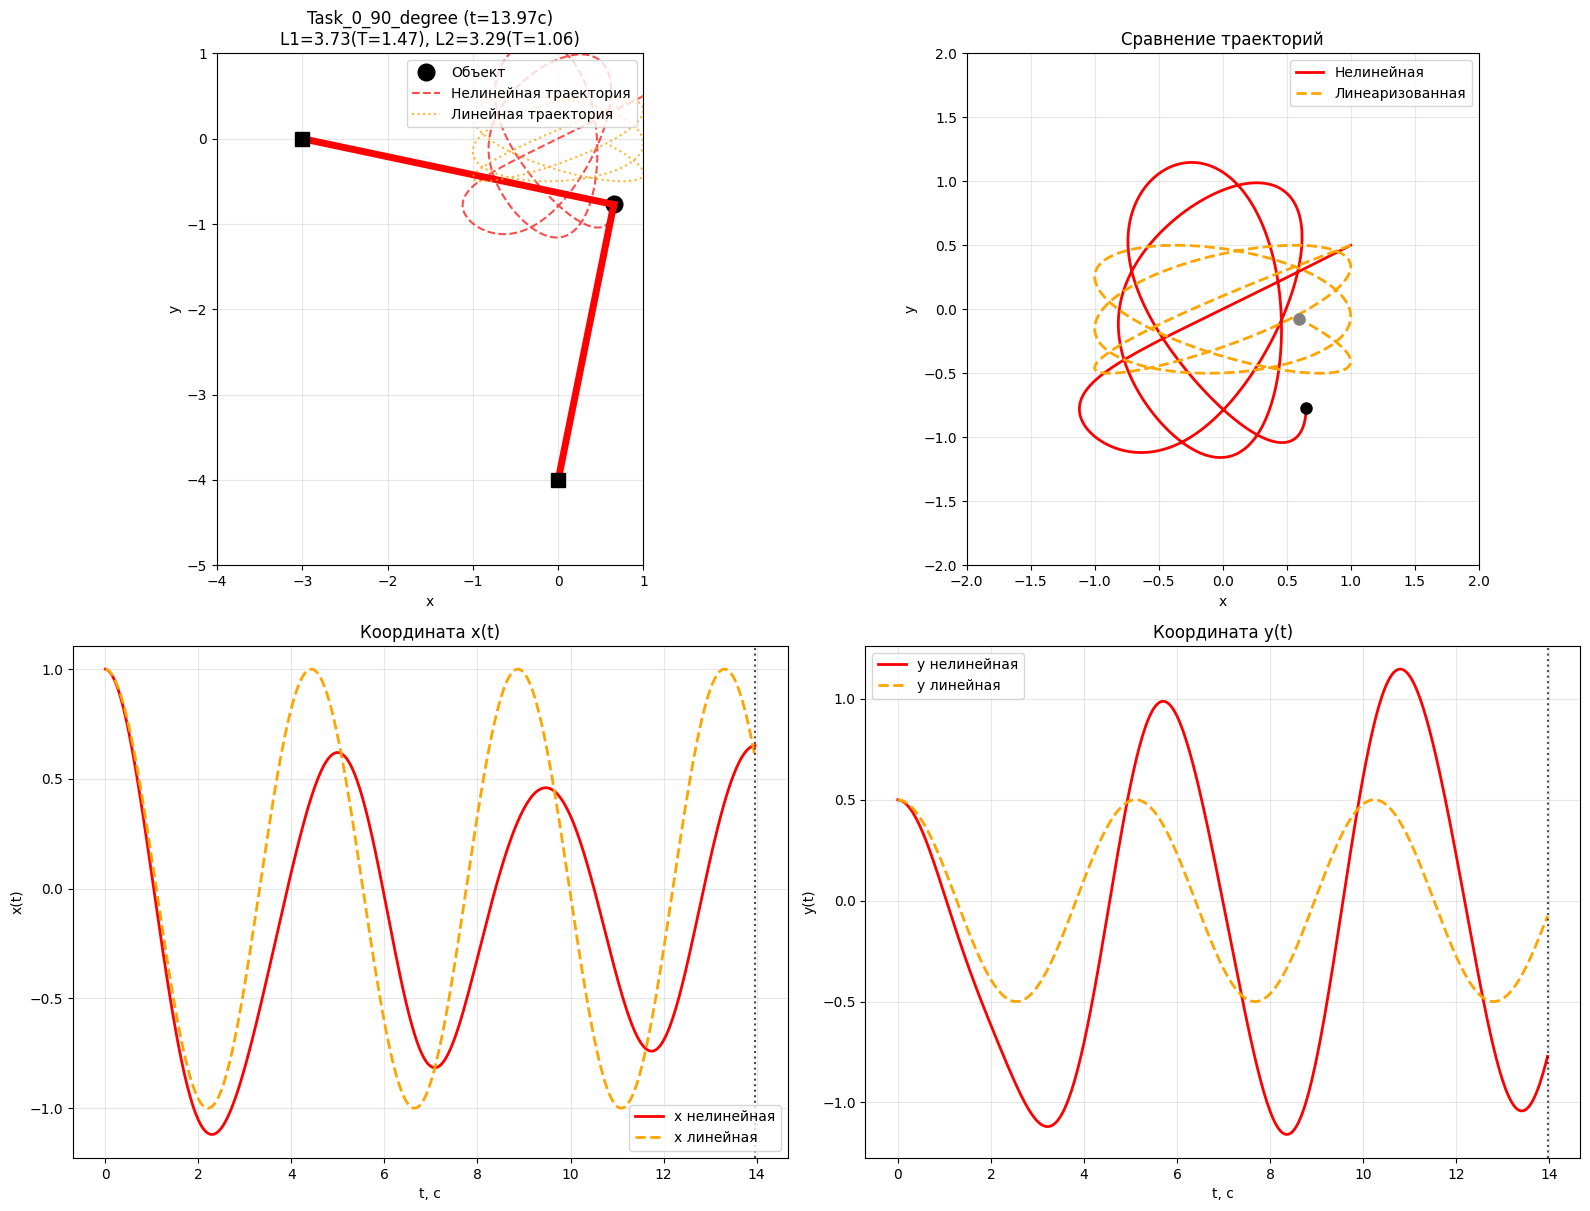

In [7]:
def anim_task_0():
    num_prms = {
        m: 1.0,
        k1: 2.0,
        k2: 1.5,
        l1_0: 3.0,
        l2_0: 4.0
    }
    
    C_xx_num = float(C_xx.subs(num_prms))
    C_xy_num = float(C_xy.subs(num_prms))
    C_yx_num = float(C_yx.subs(num_prms))
    C_yy_num = float(C_yy.subs(num_prms))
    
    x0, y0 = 1.0, 0.5
    
    def force_function_x(x_val, y_val):
        return float(Fx_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def force_function_y(x_val, y_val):
        return float(Fy_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_1(x_val, y_val):
        return float(L1_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_2(x_val, y_val):
        return float(L2_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    wall_left_x = float((-l1_0).subs(num_prms))
    wall_bottom_y = float((-l2_0).subs(num_prms))
    
    anchor_points = [(wall_left_x, 0), (0, wall_bottom_y)]
    spring_lengths = [float(l1_0.subs(num_prms)), float(l2_0.subs(num_prms))]
    spring_constants = [num_prms[k1], num_prms[k2]]
    spring_length_functions = [spring_length_1, spring_length_2]
    C_coefficients = (C_xx_num, C_xy_num, C_yx_num, C_yy_num)
    
    return create_spring_animation(
        "Task_0_90_degree",
        anchor_points, spring_lengths, spring_constants,
        force_function_x, force_function_y, spring_length_functions,
        C_coefficients, num_prms, x0, y0
    )

anim_task_0()

## Task 1

![Дополненный рисунок к 0 task](./images/pict_1.png)

### T1: Аналитическое решение

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

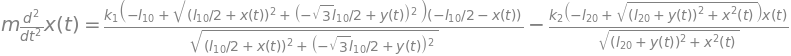

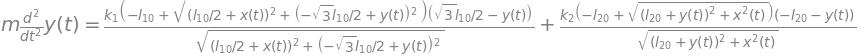

________________________________________________

Линеаризованная система уравнений:


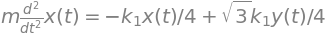

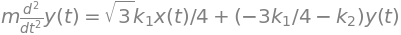

________________________________________________


In [8]:
t = sp.symbols('t')
m, k1, k2 = sp.symbols('m k1 k2', positive=True)
l10, l20 = sp.symbols('l10 l20', positive=True)

angle_val = sp.pi / 3
cos_theta = sp.cos(angle_val)
sin_theta = sp.sin(angle_val)

x_func = sp.Function('x')(t)
y_func = sp.Function('y')(t)

x_s, y_s = sp.symbols('x y')


Ax = -l10 * cos_theta
Ay = l10 * sin_theta

Bx = 0
By = -l20

vec_AP_x_s = x_s - Ax
vec_AP_y_s = y_s - Ay
vec_BP_x_s = x_s - Bx
vec_BP_y_s = y_s - By

L1_expr_s = sp.sqrt(vec_AP_x_s**2 + vec_AP_y_s**2)
L2_expr_s = sp.sqrt(vec_BP_x_s**2 + vec_BP_y_s**2)

F1_mag_s = k1 * (L1_expr_s - l10)
F2_mag_s = k2 * (L2_expr_s - l20)

F1x_s = F1_mag_s * (-vec_AP_x_s / L1_expr_s)
F1y_s = F1_mag_s * (-vec_AP_y_s / L1_expr_s)
F2x_s = F2_mag_s * (-vec_BP_x_s / L2_expr_s)
F2y_s = F2_mag_s * (-vec_BP_y_s / L2_expr_s)

Fx_total_s = F1x_s + F2x_s
Fy_total_s = F1y_s + F2y_s

Fx_total_sym = Fx_total_s
Fy_total_sym = Fy_total_s

display(Math(f"\\vec{{F}}_{{1x}} = {sp.latex(F1x_s)}"))
display(Math(f"\\vec{{F}}_{{1y}} = {sp.latex(F1y_s)}"))
display(Math(f"\\vec{{F}}_{{2x}} = {sp.latex(F2x_s)}"))
display(Math(f"\\vec{{F}}_{{2y}} = {sp.latex(F2y_s)}"))
display(Math(f"\\vec{{F}}_{{x, total}} = {sp.latex(Fx_total_sym)}"))
display(Math(f"\\vec{{F}}_{{y, total}} = {sp.latex(Fy_total_sym)}"))


force_subs = {x_s: x_func, y_s: y_func}
eq_x_full = sp.Eq(m * x_func.diff(t, 2), Fx_total_sym.subs(force_subs))
eq_y_full = sp.Eq(m * y_func.diff(t, 2), Fy_total_sym.subs(force_subs))

display(eq_x_full)
display(eq_y_full)

print(SEPARATOR)

equilibrium_point = {x_s: 0, y_s: 0}

dFx_dx = sp.diff(Fx_total_s, x_s)
dFx_dy = sp.diff(Fx_total_s, y_s)
dFy_dx = sp.diff(Fy_total_s, x_s)
dFy_dy = sp.diff(Fy_total_s, y_s)

C_xx = sp.simplify(dFx_dx.subs(equilibrium_point).doit())
C_xy = sp.simplify(dFx_dy.subs(equilibrium_point).doit())
C_yx = sp.simplify(dFy_dx.subs(equilibrium_point).doit())
C_yy = sp.simplify(dFy_dy.subs(equilibrium_point).doit())

Fx_linear = C_xx * x_func + C_xy * y_func
Fy_linear = C_yx * x_func + C_yy * y_func

eq_x_linear = sp.Eq(m * x_func.diff(t, 2), Fx_linear)
eq_y_linear = sp.Eq(m * y_func.diff(t, 2), Fy_linear)

print("\nЛинеаризованная система уравнений:")
display(eq_x_linear)
display(eq_y_linear)

print(SEPARATOR)

### T1: Визуализация

Task_1_60_degree:


C:\Users\evoni\AppData\Local\Temp\ipykernel_51844\1194476643.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_point_full, = ax2.plot([], [], 'ro', color='black', markersize=8)


Анимация сохранена: task_1_60_degree.gif


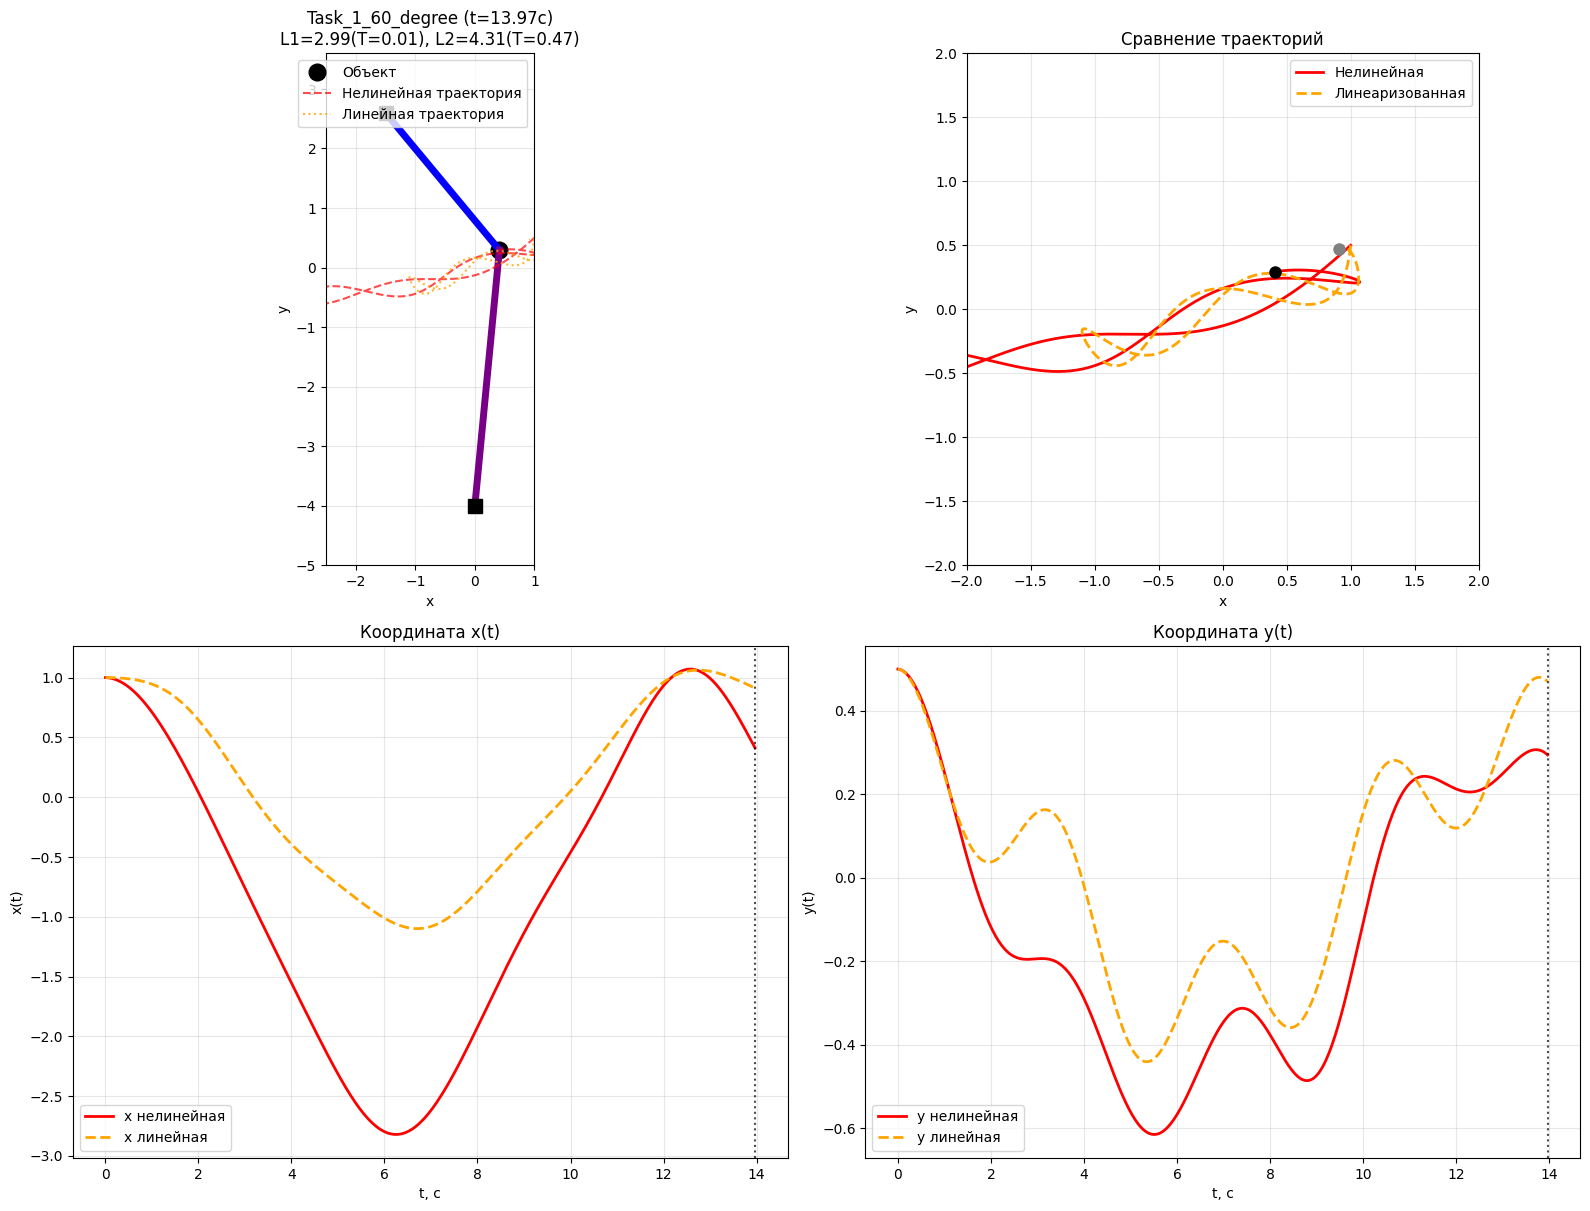

In [9]:
def anim_task_1():
    num_prms = {
        m: 1.0,
        k1: 2.0,
        k2: 1.5,
        l10: 3.0,
        l20: 4.0
    }
    
    C_xx_num = float(C_xx.subs(num_prms))
    C_xy_num = float(C_xy.subs(num_prms))
    C_yx_num = float(C_yx.subs(num_prms))
    C_yy_num = float(C_yy.subs(num_prms))
    
    x0, y0 = 1.0, 0.5
    
    def force_function_x(x_val, y_val):
        return float(Fx_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def force_function_y(x_val, y_val):
        return float(Fy_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_1(x_val, y_val):
        return float(L1_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_2(x_val, y_val):
        return float(L2_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    Ax_val = float(Ax.subs(num_prms))
    Ay_val = float(Ay.subs(num_prms))
    Bx_val = float(Bx)
    By_val = float(By.subs(num_prms))
    
    anchor_points = [(Ax_val, Ay_val), (Bx_val, By_val)]
    spring_lengths = [float(l10.subs(num_prms)), float(l20.subs(num_prms))]
    spring_constants = [num_prms[k1], num_prms[k2]]
    spring_length_functions = [spring_length_1, spring_length_2]
    C_coefficients = (C_xx_num, C_xy_num, C_yx_num, C_yy_num)
    
    return create_spring_animation(
        "Task_1_60_degree",
        anchor_points, spring_lengths, spring_constants,
        force_function_x, force_function_y, spring_length_functions,
        C_coefficients, num_prms, x0, y0
    )

anim_task_1()

## Task 2

![Дополненный рисунок к 0 task](./images/pict_2.png)

### T2: Аналитическое решение 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Компоненты сил:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

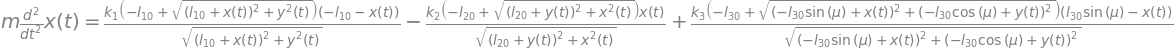

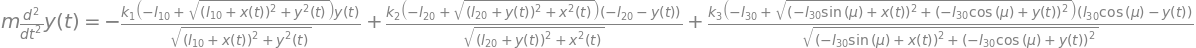

________________________________________________

Линеаризованная система уравнений:


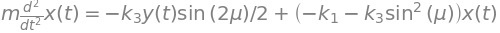

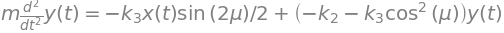

________________________________________________


In [10]:
t = sp.symbols('t')

m, k1, k2, k3 = sp.symbols('m k1 k2 k3', positive=True)
l10, l20, l30 = sp.symbols('l10 l20 l30', positive=True) 
mu = sp.symbols('mu') 

x_func = sp.Function('x')(t)
y_func = sp.Function('y')(t)

x_s, y_s = sp.symbols('x y')

A1 = (-l10, 0)
A2 = (0, -l20)
A3 = (l30 * sp.sin(mu), l30 * sp.cos(mu))

vec_A1P_x_s = x_s - A1[0]
vec_A1P_y_s = y_s - A1[1] 

vec_A2P_x_s = x_s - A2[0]
vec_A2P_y_s = y_s - A2[1] 

vec_A3P_x_s = x_s - A3[0]
vec_A3P_y_s = y_s - A3[1]

L1_expr_s = sp.sqrt(vec_A1P_x_s**2 + vec_A1P_y_s**2)
L2_expr_s = sp.sqrt(vec_A2P_x_s**2 + vec_A2P_y_s**2)
L3_expr_s = sp.sqrt(vec_A3P_x_s**2 + vec_A3P_y_s**2)

display(Math(f"l_1 = {sp.latex(L1_expr_s)}"))
display(Math(f"l_2 = {sp.latex(L2_expr_s)}"))
display(Math(f"l_3 = {sp.latex(L3_expr_s)}"))

F1_mag_s = k1 * (L1_expr_s - l10)
F2_mag_s = k2 * (L2_expr_s - l20)
F3_mag_s = k3 * (L3_expr_s - l30)

F1x_s = F1_mag_s * (-vec_A1P_x_s / L1_expr_s)
F1y_s = F1_mag_s * (-vec_A1P_y_s / L1_expr_s)

F2x_s = F2_mag_s * (-vec_A2P_x_s / L2_expr_s)
F2y_s = F2_mag_s * (-vec_A2P_y_s / L2_expr_s)

vec_PA3_x_s = A3[0] - x_s 
vec_PA3_y_s = A3[1] - y_s

F3x_s = F3_mag_s * (vec_PA3_x_s / L3_expr_s)
F3y_s = F3_mag_s * (vec_PA3_y_s / L3_expr_s)

print("Компоненты сил:")
display(Math(f"F_{{1x}} = {sp.latex(F1x_s)}"))
display(Math(f"F_{{1y}} = {sp.latex(F1y_s)}"))
display(Math(f"F_{{2x}} = {sp.latex(F2x_s)}"))
display(Math(f"F_{{2y}} = {sp.latex(F2y_s)}"))
display(Math(f"F_{{3x}} = {sp.latex(F3x_s)}"))
display(Math(f"F_{{3y}} = {sp.latex(F3y_s)}"))

# Суммарные силы по осям
Fx_total_s = F1x_s + F2x_s + F3x_s
Fy_total_s = F1y_s + F2y_s + F3y_s

Fx_total_sym = Fx_total_s
Fy_total_sym = Fy_total_s

display(Math(f"F_{{x, total}} = {sp.latex(Fx_total_sym)}"))
display(Math(f"F_{{y, total}} = {sp.latex(Fy_total_sym)}"))

force_subs = {x_s: x_func, y_s: y_func}
eq_x_full = sp.Eq(m * x_func.diff(t, 2), Fx_total_sym.subs(force_subs))
eq_y_full = sp.Eq(m * y_func.diff(t, 2), Fy_total_sym.subs(force_subs))

display(eq_x_full)
display(eq_y_full)

print(SEPARATOR)

equilibrium_point = {x_s: 0, y_s: 0}

dFx_dx = sp.diff(Fx_total_sym, x_s)
dFx_dy = sp.diff(Fx_total_sym, y_s)
dFy_dx = sp.diff(Fy_total_sym, x_s)
dFy_dy = sp.diff(Fy_total_sym, y_s)

C_xx = sp.simplify(dFx_dx.subs(equilibrium_point))
C_xy = sp.simplify(dFx_dy.subs(equilibrium_point))
C_yx = sp.simplify(dFy_dx.subs(equilibrium_point))
C_yy = sp.simplify(dFy_dy.subs(equilibrium_point))

Fx_linear = C_xx * x_func + C_xy * y_func
Fy_linear = C_yx * x_func + C_yy * y_func

eq_x_linear = sp.Eq(m * x_func.diff(t, 2), Fx_linear)
eq_y_linear = sp.Eq(m * y_func.diff(t, 2), Fy_linear)

print("\nЛинеаризованная система уравнений:")
display(eq_x_linear)
display(eq_y_linear)

print(SEPARATOR)

### T2: Визуализация

Task_2_3_springs:


C:\Users\evoni\AppData\Local\Temp\ipykernel_51844\1194476643.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_point_full, = ax2.plot([], [], 'ro', color='black', markersize=8)


Анимация сохранена: task_2_3_springs.gif


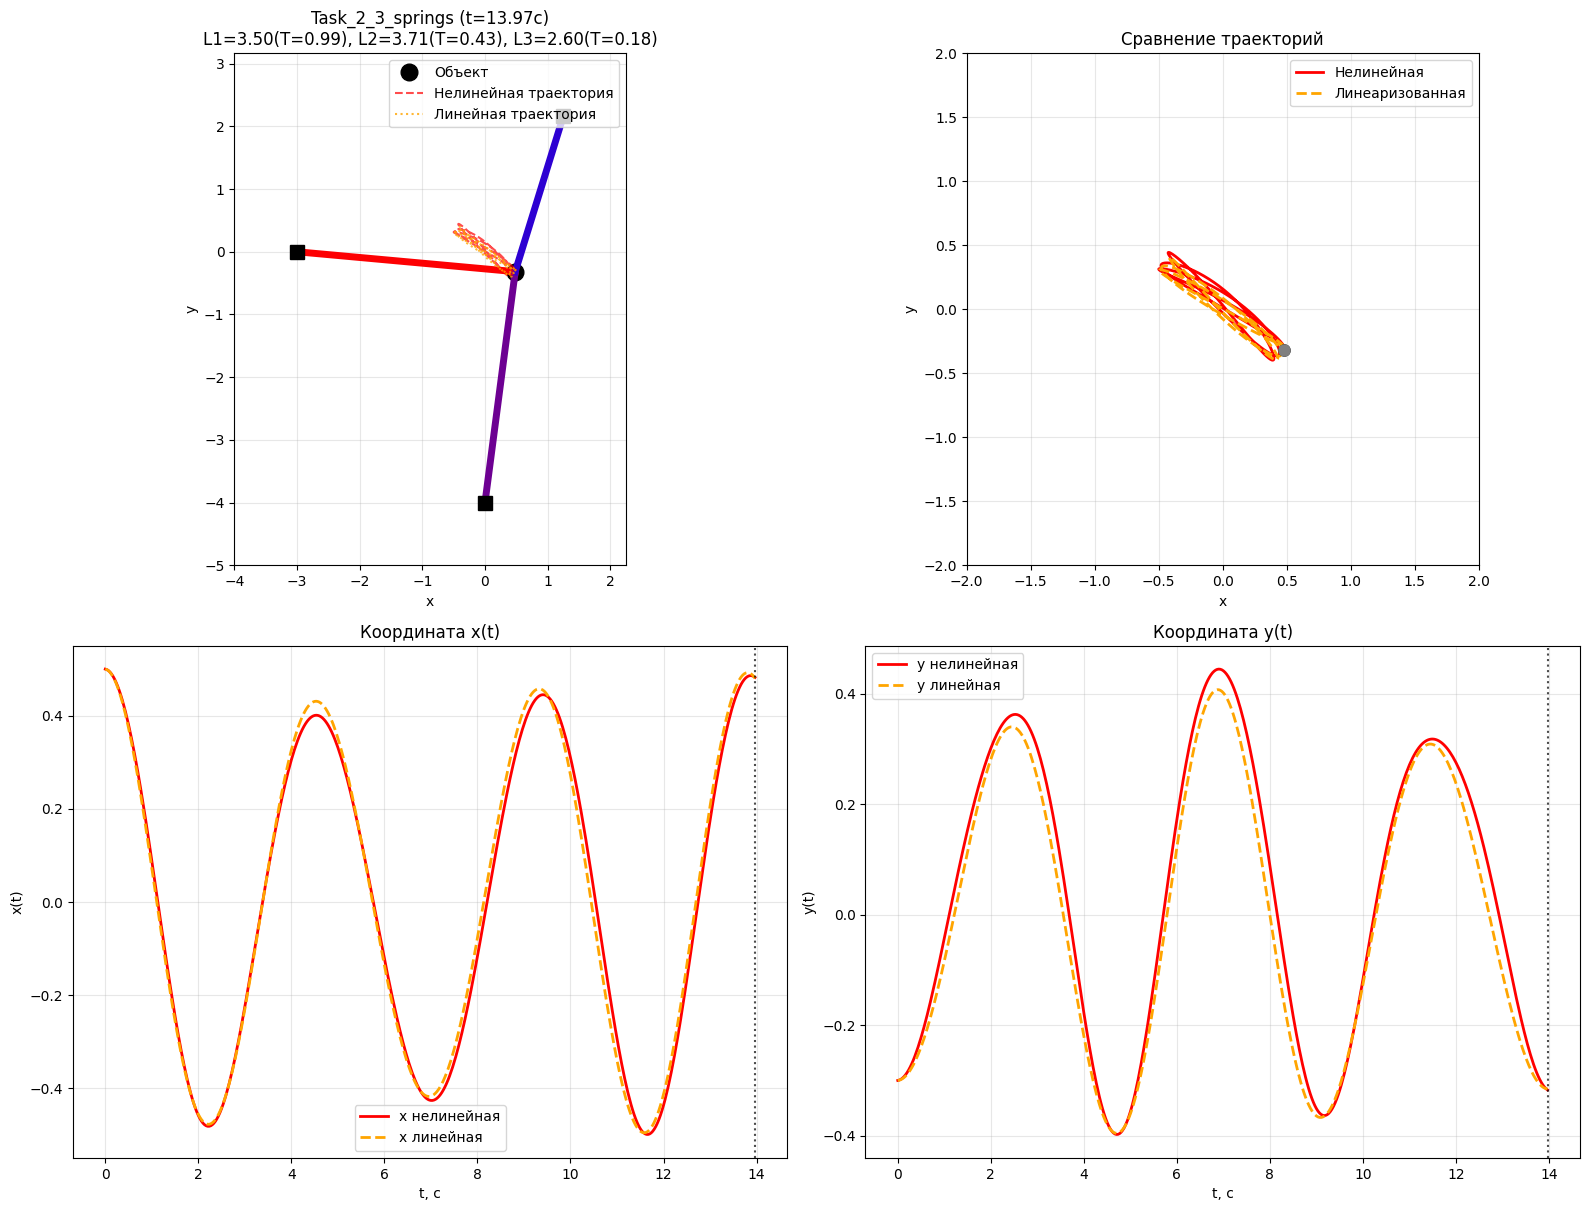

In [11]:
def anim_task_2():
    num_prms = {
        m: 1.0,
        k1: 2.0,
        k2: 1.5,
        k3: 1.8,
        l10: 3.0,
        l20: 4.0,
        l30: 2.5,
        mu: sp.pi/6
    }
    
    C_xx_num = float(C_xx.subs(num_prms))
    C_xy_num = float(C_xy.subs(num_prms))
    C_yx_num = float(C_yx.subs(num_prms))
    C_yy_num = float(C_yy.subs(num_prms))
    
    x0, y0 = 0.5, -0.3
    
    def force_function_x(x_val, y_val):
        return float(Fx_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def force_function_y(x_val, y_val):
        return float(Fy_total_sym.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_1(x_val, y_val):
        return float(L1_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_2(x_val, y_val):
        return float(L2_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    def spring_length_3(x_val, y_val):
        return float(L3_expr_s.subs({x_s: x_val, y_s: y_val, **num_prms}))
    
    A1_coords = (float(A1[0].subs(num_prms)), float(A1[1]))
    A2_coords = (float(A2[0]), float(A2[1].subs(num_prms)))
    A3_coords = (float(A3[0].subs(num_prms)), float(A3[1].subs(num_prms)))
    
    anchor_points = [A1_coords, A2_coords, A3_coords]
    spring_lengths = [float(l10.subs(num_prms)), float(l20.subs(num_prms)), float(l30.subs(num_prms))]
    spring_constants = [num_prms[k1], num_prms[k2], num_prms[k3]]
    spring_length_functions = [spring_length_1, spring_length_2, spring_length_3]
    C_coefficients = (C_xx_num, C_xy_num, C_yx_num, C_yy_num)
    
    return create_spring_animation(
        "Task_2_3_springs",
        anchor_points, spring_lengths, spring_constants,
        force_function_x, force_function_y, spring_length_functions,
        C_coefficients, num_prms, x0, y0
    )

anim_task_2()